In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import h5py 
import utils 
from scipy import fftpack

# Description of data

We have 44 nights (subjects) of 200 windows (samples) of 90 seconds sampled at 100 Hz (so 9000 points per window)

Half of the 44 nights are in the training set (so **4400 samples**) and the other half in the test set

Each window has **8 features so 72000 points** + 2 indexes :

- 0: sample index
- 1: subject index
- 2 to 9001: Abdominal belt
- 9002 to 18001: Airflow
- 18002 to 27001: PPG (Photoplethysmogram)
- 27002 to 36001: Thoracic belt
- 36002 to 45001: Snoring indicator
- 45002 to 54001: SPO2
- 54002 to 63001: C4-A1
- 63002 to 72001:O2-A1

In [2]:
# Step 1. Collect data 

In [3]:
SIGNALS_NAME = [
    "AbdoBelt",
    "AirFlow",
    "PPG",
    "ThorBelt",
    "Snoring",
    "SPO2",
    "C4A1",
    "O2A1",
]

In [4]:
data_x_train = h5py.File('../data/X_train.h5')
data_x_test = h5py.File('../data/X_test.h5')
data_x_train['data'].shape, data_x_test['data'].shape

((4400, 72002), (4400, 72002))

**Description of masks**

X mask is a stairway function that tells us which subjects corresponds to each sample 

Y mask is our target: it tells us for every sample if the subject is in apnea for each **second**

In [5]:
mask_x_train = np.array(pd.read_csv('../data/X_train.csv'))
mask_x_test = np.array(pd.read_csv('../data/X_test.csv'))
mask_y_train = np.array(pd.read_csv('../data/y_train.csv'))
mask_y_subject = mask_y_train[:,1:].reshape(22,-1)
mask_x_train.shape, mask_x_test.shape, mask_y_train.shape, mask_y_subject.shape

((4400, 2), (4400, 2), (4400, 91), (22, 18000))

number of subjects with apnea in 0 samples: 0


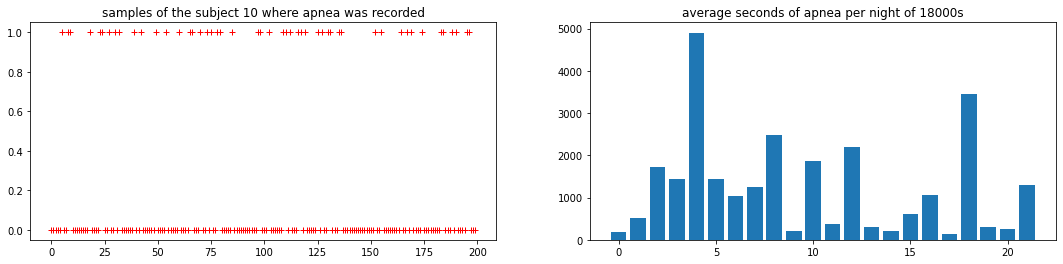

In [7]:
sick_sample = np.max(mask_y_train[:,1:],axis = 1)
sick_patient = np.max(sick_sample.reshape(22,200), axis = 1)
print('number of subjects with apnea in 0 samples:', 22 - sum(sick_patient))
subject = np.random.randint(22) # ; subject = 4 # (for worst case)
plt.subplot(121)
plt.plot(sick_sample[subject*200:subject*200+200],'r+')
plt.title('samples of the subject ' + str(subject) + ' where apnea was recorded')
plt.subplot(122)
plt.bar( range(22), np.sum(mask_y_subject,axis=1))
plt.title('average seconds of apnea per night of 18000s' )
plt.subplots_adjust(right=2.5)

# possible representations of X and Y
- possible other feature: use the results from the previous samples from the same subject 
- possible other feature: add 15 previous seconds (with their results)

representation 1: one window = X --> CNN
- X: 9000*8
- Y: 90
 4400 samples

representation 1bis: sub-sampling from one window = X --> CNN
- X: 9000/**rate** *8 , rate tbd between 1 and 100
- Y: 90

representation 2: one second = X --> CNN into LSTM or SVM 
- X: 100*8
- Y: 1
4400*90= 396000 samples

representation 2bis: last **N** seconds = X to predict one second --> SVM
- X: 100\*8\***N** /**rate**,  , rate tbd between 1 and 100, N tbd between 1 and 15
- Y: 1
- 4400*90= 396000 samples

representation 3: one point = X --> LSTM
- X= 8
- Y = 1 
4400*9000 samples




In [8]:
# 2. Analyse Data 
# - Get base frequency 
# - Analyse repartition of data w and w/o sleepapnea


In [9]:
#Get mean and variance of each data 
train = utils.subsampling_data(data_x_train, 10, 0)
test = utils.subsampling_data(data_x_test, 10, 0)


In [10]:
rate = 10
print(train.shape)
print(test.shape) 
print(train[1][2].shape)

(4400, 8, 900)
(4400, 8, 900)
(900,)


In [11]:
windowed_mean, windowed_variance = utils.get_mean_variance(train,SIGNALS_NAME)


In [12]:
windowed_mean.mean(), '', windowed_variance.mean()

(AbdoBelt        5.888035
 AirFlow       -28.403486
 PPG          -857.776287
 ThorBelt       -9.012861
 Snoring       693.812603
 SPO2        91942.331172
 C4A1            0.000448
 O2A1           -0.000134
 dtype: float64,
 '',
 AbdoBelt    2.282064e+05
 AirFlow     3.216563e+03
 PPG         2.109008e+06
 ThorBelt    1.841298e+05
 Snoring     5.844458e+02
 SPO2        7.109421e+07
 C4A1        3.803098e+02
 O2A1        3.649627e+02
 dtype: float64)

In [13]:
print(sick_sample.shape)
print(sick_patient)
print(mask_y_train[:,1:].shape)
print(mask_y_train.shape)


(4400,)
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]
(4400, 90)
(4400, 91)


In [14]:
a, n = utils.separate_data(train, mask_y_train,norm=1)
print(a.size(), b.size())


Text(0.5, 1.0, "Valeur moyenne de chaque feature en stade d'apnée et non-apnée")

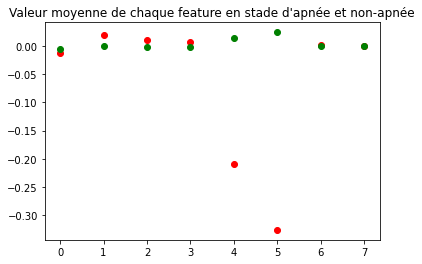

In [15]:
#print(a.shape)
#print(n.shape)
plt.scatter([0, 1, 2, 3 ,4, 5, 6, 7],a.mean(axis=0), color='red')
plt.scatter([0,1,2,3,4,5,6,7],n.mean(axis=0), color ='green')
plt.title("Valeur moyenne de chaque feature en stade d'apnée et non-apnée")
#"plt.legend(blue, red)
#print(a.var(axis=0))
#print(n.var(axis=0))



Text(0.5, 1.0, "variance moyenne de chaque feature en stade d'apnée et non-apnée")

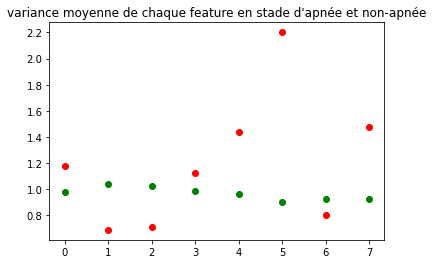

In [16]:
#print(a.shape)
#print(n.shape)
plt.scatter([0, 1, 2, 3 ,4, 5, 6, 7],a.var(axis=0), color='red')
plt.scatter([0,1,2,3,4,5,6,7],n.var(axis=0), color ='green')
plt.title("variance moyenne de chaque feature en stade d'apnée et non-apnée")
#"plt.legend(blue, red)
#print(a.var(axis=0))
#print(n.var(axis=0))


In [17]:
mean_data = utils.subsampling_data(data_x_train, 100)
mean_var = utils.subsampling_data_var(data_x_train, 100)


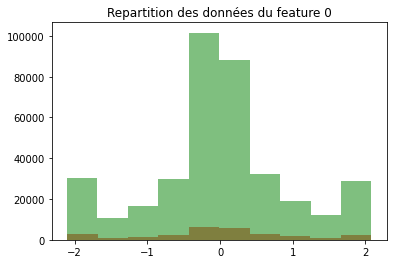

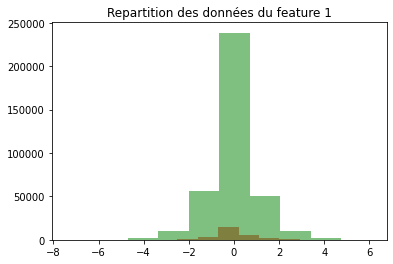

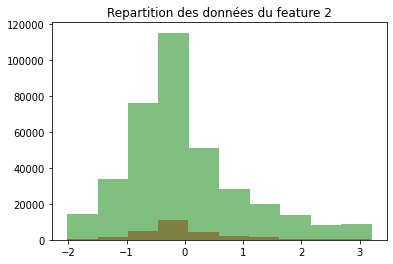

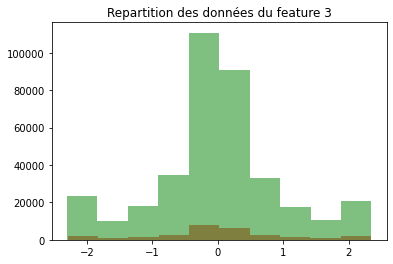

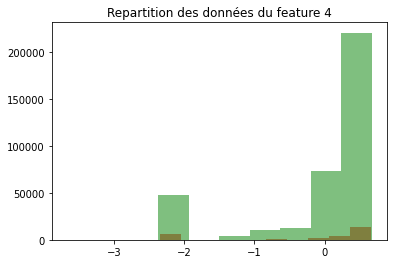

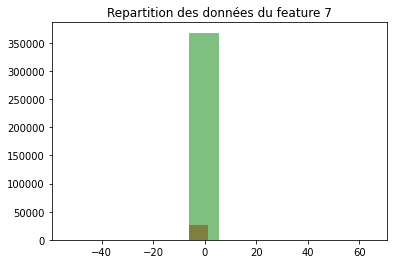

In [18]:
for i in range(8):
    fig = plt
    fig.hist(a[:,i],alpha = 0.5, color='red')
    fig.hist(n[:,i], alpha = 0.5, color='green')
    fig.title('Repartition des données du feature %d' %i)
    fig.show()

In [19]:
a.shape, n.shape

((26948, 8), (369052, 8))

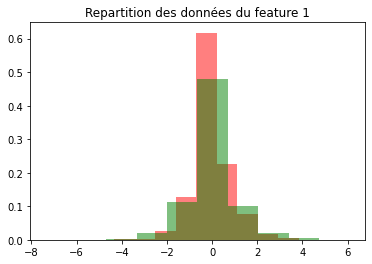

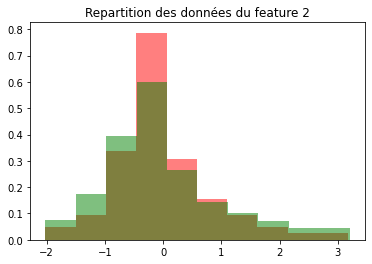

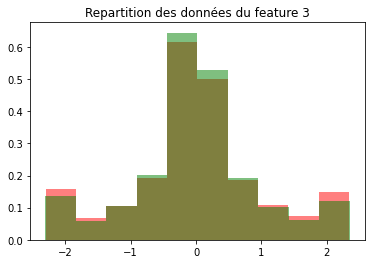

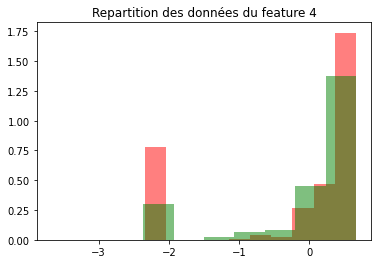

In [20]:
for i in range(8):
    fig = plt
    fig.hist(a[:,i],alpha = 0.5, color='red', density=True)
    fig.hist(n[:,i], alpha = 0.5, color='green', density=True)
    fig.title('Repartition des données du feature %d' %i)
    fig.show()

Nombre d'échantillons :  900
Fréquence d'échantillonnage :  100


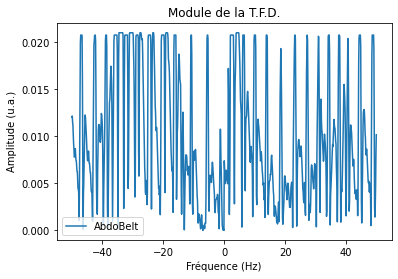

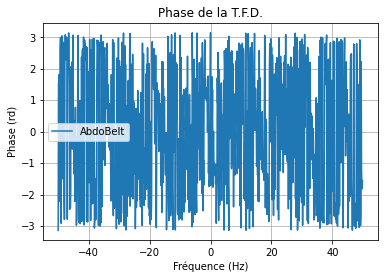

-0.5 0.4988888888888889
Nombre d'échantillons :  900
Fréquence d'échantillonnage :  100


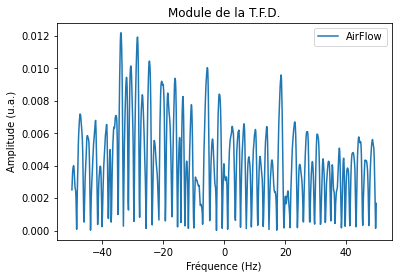

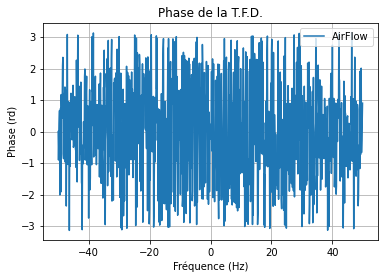

-0.5 0.4988888888888889
Nombre d'échantillons :  900
Fréquence d'échantillonnage :  100


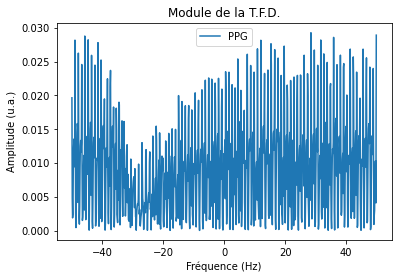

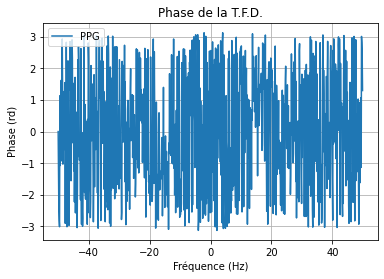

-0.5 0.4988888888888889
Nombre d'échantillons :  900
Fréquence d'échantillonnage :  100


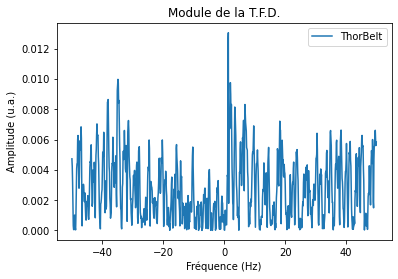

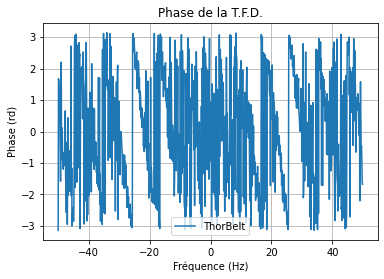

-0.5 0.4988888888888889
Nombre d'échantillons :  900
Fréquence d'échantillonnage :  100


-0.5 0.4988888888888889
Nombre d'échantillons :  900
Fréquence d'échantillonnage :  100


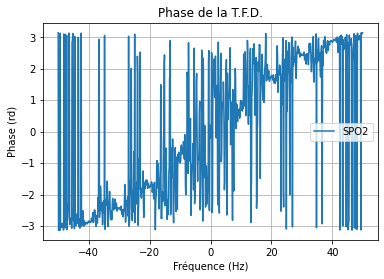

-0.5 0.4988888888888889
Nombre d'échantillons :  900
Fréquence d'échantillonnage :  100


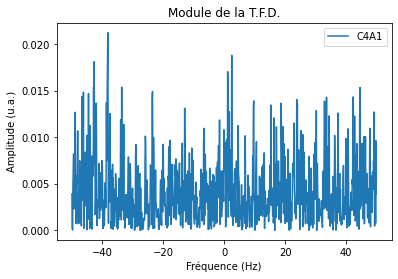

-0.5 0.4988888888888889
Nombre d'échantillons :  900
Fréquence d'échantillonnage :  100


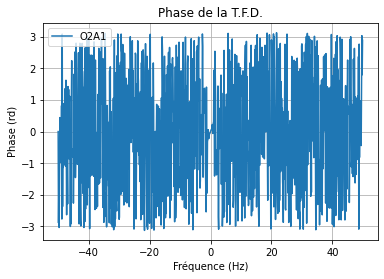

-0.5 0.4988888888888889


In [22]:
freq= np.zeros(len(SIGNALS_NAME))
for i in range(len(SIGNALS_NAME)):
    freq[i] = utils.base_freq(train[13, i], i, 100, SIGNALS_NAME)



In [23]:
print(freq)

[ 2.88888889  2.88888889 10.33333333  2.88888889  0.          0.
  4.88888889  5.22222222]
